In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns



# Loading the data

In [2]:
# Load the dataset
data = pd.read_csv('train2.csv')

# Preprocess data
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(', '))
X = vectorizer.fit_transform(data['ingredients'].astype(str))

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['cuisine'])

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


# Creating dataset class

In [3]:
class RecipeDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        return torch.FloatTensor(self.X[index].toarray()[0]), torch.tensor(self.y[index])

# Create datasets and dataloaders
train_dataset = RecipeDataset(X_train, y_train)
val_dataset = RecipeDataset(X_val, y_val)
test_dataset = RecipeDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


# Create MLP model

## Training and Evaluation

In [13]:
import torch.nn.functional as F

class CuisineClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.5):
        super(CuisineClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.numpy())
            all_predictions.extend(predicted.numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    return avg_loss, accuracy, precision, recall, f1

def plot_confusion_matrix(labels, predictions, class_names):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Initialize the model
input_size = X_train.shape[1]
output_size = len(label_encoder.classes_)
hidden_size = 128
advanced_model = CuisineClassifier(input_size, hidden_size, output_size)

# Choose an optimizer and adjust learning rate if needed
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(advanced_model.parameters(), lr=0.001)

# Train the model
num_epochs = 5

for epoch in range(num_epochs):
    advanced_model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = advanced_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = (correct_train / total_train) * 100

    # Validation
    val_loss, val_accuracy, val_precision, val_recall, val_f1 = evaluate_model(advanced_model, val_loader, criterion)

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, '
          f'Validation Precision: {val_precision:.4f}, Validation Recall: {val_recall:.4f}, Validation F1: {val_f1:.4f}')


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/5], Train Loss: 1.5065, Train Accuracy: 58.44%, Validation Loss: 0.9842, Validation Accuracy: 0.72%, Validation Precision: 0.7265, Validation Recall: 0.7169, Validation F1: 0.6860
Epoch [2/5], Train Loss: 0.8601, Train Accuracy: 75.35%, Validation Loss: 0.8336, Validation Accuracy: 0.76%, Validation Precision: 0.7571, Validation Recall: 0.7598, Validation F1: 0.7492
Epoch [3/5], Train Loss: 0.6466, Train Accuracy: 81.40%, Validation Loss: 0.7897, Validation Accuracy: 0.77%, Validation Precision: 0.7692, Validation Recall: 0.7699, Validation F1: 0.7638
Epoch [4/5], Train Loss: 0.5055, Train Accuracy: 85.45%, Validation Loss: 0.7840, Validation Accuracy: 0.77%, Validation Precision: 0.7689, Validation Recall: 0.7684, Validation F1: 0.7639
Epoch [5/5], Train Loss: 0.4105, Train Accuracy: 88.10%, Validation Loss: 0.8000, Validation Accuracy: 0.77%, Validation Precision: 0.7634, Validation Recall: 0.7653, Validation F1: 0.7607


# Accuracy 77%

Test Loss: 0.8098, Test Accuracy: 0.76%, Test Precision: 0.7565, Test Recall: 0.7585, Test F1: 0.7533


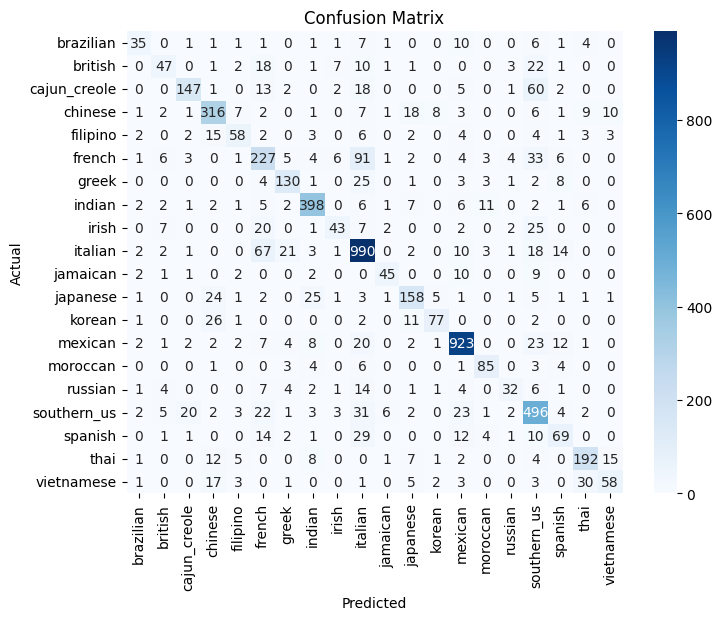

In [14]:
# Evaluate the advanced model on the test set
test_loss, test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(advanced_model, test_loader, criterion)

print(f'Test Loss: {test_loss:.4f}, '
      f'Test Accuracy: {test_accuracy:.2f}%, '
      f'Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1: {test_f1:.4f}')

# Generate predictions and plot confusion matrix
advanced_model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = advanced_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.numpy())
        all_predictions.extend(predicted.numpy())

# Get class names from label_encoder
class_names = list(label_encoder.classes_)

# Plot confusion matrix
plot_confusion_matrix(all_labels, all_predictions, class_names)